In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from collections import Counter

client = Client(processes=False)
df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
df.time_created = df.time_created.astype('uint32')
df.up_votes = df.up_votes.astype('uint16')
df.down_votes = df.down_votes.astype('uint16')

df = client.persist(df)
print df.dtypes

time_created    uint32
date_created    object
up_votes        uint16
down_votes      uint16
title           object
over_18           bool
author          object
category        object
dtype: object


In [4]:
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
sampled_df = df.sample(frac=0.05)
sampled_titles = sampled_df['title'].compute().values
sampled_up_votes = sampled_df['up_votes'].compute().values
print "title_sample:{}".format(sampled_titles)
#print "title_sample.tolist:{}".format(sampled_titles.tolist())

print('Title before vectorization: {}'.format(sampled_titles[1]))

sampled_document_term_matrix = count_vectorizer.fit_transform(sampled_titles)

print('Title after vectorization: \n{}'.format(sampled_document_term_matrix[1]))
# dictionary = corpora.Dictionary([sampled_titles])
# doc_term_matrix = [dictionary.doc2bow(doc) for doc in [sampled_titles]]
# print "doc_term_matrix:{}".format(doc_term_matrix)

def tokenize_titles(titles):

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for title in titles:
        raw = title.decode('utf-8').strip().lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if not token in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

words = tokenize_titles(sampled_titles)
dictionary = corpora.Dictionary(words)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]
# print "words:{}".format(words)
# print "dictionary:{}".format(dictionary)
# print "doc_term_matrix:{}".format(doc_term_matrix)

title_sample:['North Korea produced a 53,000 word report on how great it s human rights record is'
 'Syrian troops attack Deraa, cradle of uprising'
 'More than a million displaced in Iraq' ...
 'US court rules Iran must pay terrorism victims $2bn'
 'UK is the best place in the world to die, according to end-of-life care index'
 'Obama criticizes China s  problematic  human rights record']
Title before vectorization: Syrian troops attack Deraa, cradle of uprising
Title after vectorization: 
  (0, 23002)	1
  (0, 5596)	1
  (0, 6403)	1
  (0, 2170)	1
  (0, 22444)	1
  (0, 21472)	1


determining the number of topics
coherence scores: [0.22277300438336103, 0.22908431454791742, 0.23702833195214787, 0.23426625054560396, 0.23285004436484255, 0.25065391074184085, 0.2381228764540188, 0.24726319615892992, 0.2561906928381645, 0.2530697023661786, 0.2507875041358275, 0.26012336884218484, 0.26735654859003083, 0.2597604226569383, 0.2668629847981703, 0.24815104191529305, 0.2566571999713721, 0.24713318608428006, 0.25855783137815813, 0.2473054813500464, 0.2483508526145255, 0.25202770409140457, 0.24690817098854415, 0.24694885682016943, 0.24544288102986644, 0.2403956240784353, 0.24052577698786967, 0.2366020976781284, 0.2433540076403719, 0.2397741271015468, 0.23130199546746816, 0.2428068272647674, 0.236157577743633, 0.24526615364027465, 0.23004731566460532, 0.23451834136025893, 0.2311020424943014, 0.23559037202065403, 0.23884408495718046, 0.2399103134262361, 0.23960121547322805, 0.24139638395486562, 0.24267416542408632, 0.24074200718231506, 0.24641931087504088, 0.24416186621914376, 

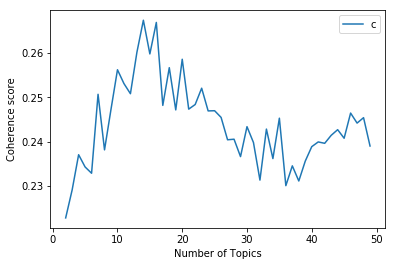

In [5]:
print "determining the number of topics"
def compute_plot_coherence_values(doc_term_matrix, stop, start=2, step=1):

    coherence_values = []
    model_list = []
    num_options = range(start, stop, step)
    for num_topics in num_options:
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    print "coherence scores: {}".format(coherence_values)
    print "plotting coherence score for different number of topics" 
    plt.plot(num_options, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence scores"), loc='best')
    plt.show()

compute_plot_coherence_values(doc_term_matrix, 50, 2, 1)

In [6]:
print "setting num of topics to be 14"
n_topics = 14
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(sampled_document_term_matrix)
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

top_n_words_lsa = get_top_n_words(10, lsa_keys, sampled_document_term_matrix, count_vectorizer)
for idx, top_words in enumerate(top_n_words_lsa):
    print("Topic {}: ".format(idx + 1), ','.join(top_words.split(' ')))

setting num of topics to be 14
('Topic 1: ', u'says,government,minister,attack,military,said,year,uk,years,court')
('Topic 2: ', u'china,sea,south,japan,chinese,new,korea,beijing,world,says')
('Topic 3: ', u'new,government,year,police,years,world,zealand,people,law,000')
('Topic 4: ', u'korea,north,south,korean,nuclear,kim,jong,says,missile,test')
('Topic 5: ', u'new,says,zealand,russia,iran,study,snowden,eu,york,world')
('Topic 6: ', u'syria,russia,assad,isis,war,rebels,al,turkey,syrian,russian')
('Topic 7: ', u'israel,iran,israeli,gaza,palestinian,nuclear,deal,talks,hamas,palestinians')
('Topic 8: ', u'russia,ukraine,russian,putin,uk,crisis,eu,news,world,crimea')
('Topic 9: ', u'world,news,bbc,cup,war,largest,people,india,health,uk')
('Topic 10: ', u'police,arrest,protesters,attack,say,officers,attacks,killed,french,protest')
('Topic 11: ', u'killed,people,000,dead,attack,israeli,gaza,injured,year,wounded')
('Topic 12: ', u'state,islamic,israel,iraq,group,said,militants,attack,says,i

visualizing num of titles under each topic
lsa_categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
lsa_counts:[15096, 1149, 336, 756, 786, 824, 1411, 1156, 892, 616, 924, 490, 406, 620]


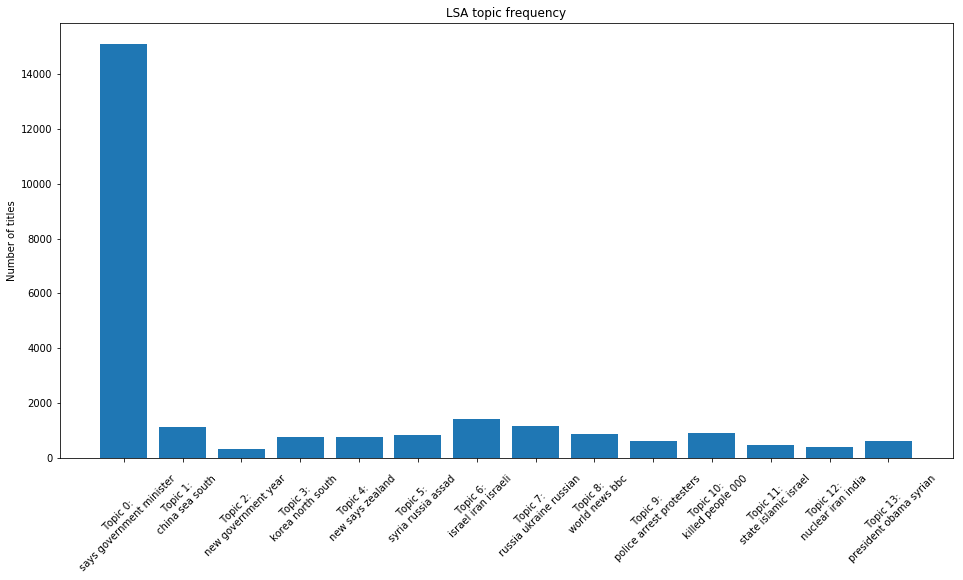

In [7]:
print "visualizing num of titles under each topic"
top_3_words = get_top_n_words(3, lsa_keys, sampled_document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
print "lsa_categories:{}".format(lsa_categories)
print "lsa_counts:{}".format(lsa_counts)
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
plt.xticks(rotation=45)
ax.set_xticklabels(labels);
ax.set_ylabel('Number of titles');
ax.set_title('LSA topic frequency');
plt.show()

In [8]:
print "use t-SNE to visualize LSA high dimensional dataset"
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

use t-SNE to visualize LSA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.023s...
[t-SNE] Computed neighbors for 25462 samples in 8.053s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabilities for sample 6000 / 25462
[t-SNE] Computed conditional probabilities for sample 7000 / 25462
[t-SNE] Computed conditional probabilities for sample 8000 / 25462
[t-SNE] Computed conditional probabilities for sample 9000 / 25462
[t-SNE] Computed conditional probabilities for sample 10000 / 25462
[t-SNE] Computed conditional probabilities for sample 11000 / 25462
[t-SNE] Computed conditional probabilities for sample 12000 / 254

tsne_lsa_vectors:[[-13.773856  -69.380005 ]
 [-12.840269  -16.97684  ]
 [ -3.0783346 -36.438442 ]
 ...
 [-47.870316   29.499664 ]
 [ 48.58576    55.2987   ]
 [-74.819786   10.751824 ]], 25462 vectors


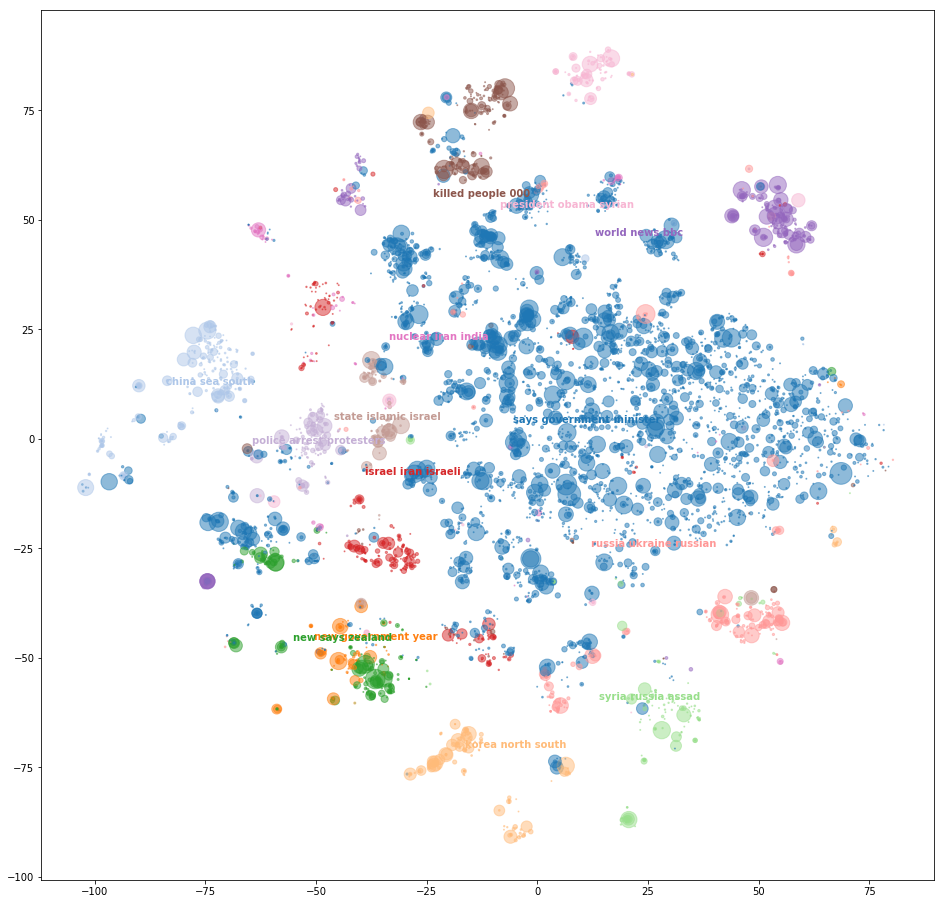

In [9]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    centroid_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        centroid_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        centroid_topic_vectors.append(centroid_article_in_that_topic)
    return centroid_topic_vectors
print "tsne_lsa_vectors:{}, {} vectors".format(tsne_lsa_vectors, len(tsne_lsa_vectors))
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)
colormap = np.array([
    "#1f77b5", "#aec7e9", "#ff7f0f", "#ffbb79", "#2ca02d",
    "#98df8b", "#d62729", "#ff9897", "#9467be", "#c5b0d6",
    "#8c564c", "#c49c95", "#e377c3", "#f7b6d3", "#7f7f80",
    "#c7c7c8", "#bcbd23", "#dbdb8e", "#17bed0", "#9edae6" ])
colormap = colormap[:n_topics]
proportion = 20;
sampled_up_votes_sizes = sampled_up_votes / proportion;
fig, ax = plt.subplots(figsize=(16,16))
plt.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1],
            color=colormap[lsa_keys],
            marker='o', s=sampled_up_votes_sizes, alpha=0.5)
for t in range(n_topics):
    plt.text(lsa_mean_topic_vectors[t][0],
             lsa_mean_topic_vectors[t][1],
             top_3_words[t], color=colormap[t],
             horizontalalignment='center', weight='bold')
plt.show()

In [10]:
print "Try LDA"
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0, verbose=1)
lda_topic_matrix = lda_model.fit_transform(sampled_document_term_matrix)

Try LDA
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [11]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)
top_10_words_lda = get_top_n_words(10, lda_keys, sampled_document_term_matrix, count_vectorizer)

print "top 10 topic words by LDA:"
for idx, topic in enumerate(top_10_words_lda):
    print("Topic {}: ".format(idx + 1), topic)


top 10 topic words by LDA:
('Topic 1: ', u'russia ukraine eu syria nato says weapons border near sanctions')
('Topic 2: ', u'climate change iraq million government thousands india national world new')
('Topic 3: ', u'court death bbc ban news life china world france chinese')
('Topic 4: ', u'al isis says said minister government new ebola qaeda german')
('Topic 5: ', u'attack french syrian rebels dies earthquake japan china syria car')
('Topic 6: ', u'china syria saudi minister arabia sea city forces south says')
('Topic 7: ', u'uk russia putin pope president says snowden arrested years government')
('Topic 8: ', u'pakistan egypt election indian australia air china space bin laden')
('Topic 9: ', u'new killed people japan india years death china toll afghanistan')
('Topic 10: ', u'state year israeli islamic president old obama man new peace')
('Topic 11: ', u'israel new news palestinian gaza iran hamas israeli bank palestinians')
('Topic 12: ', u'police turkey syrian military anti prote

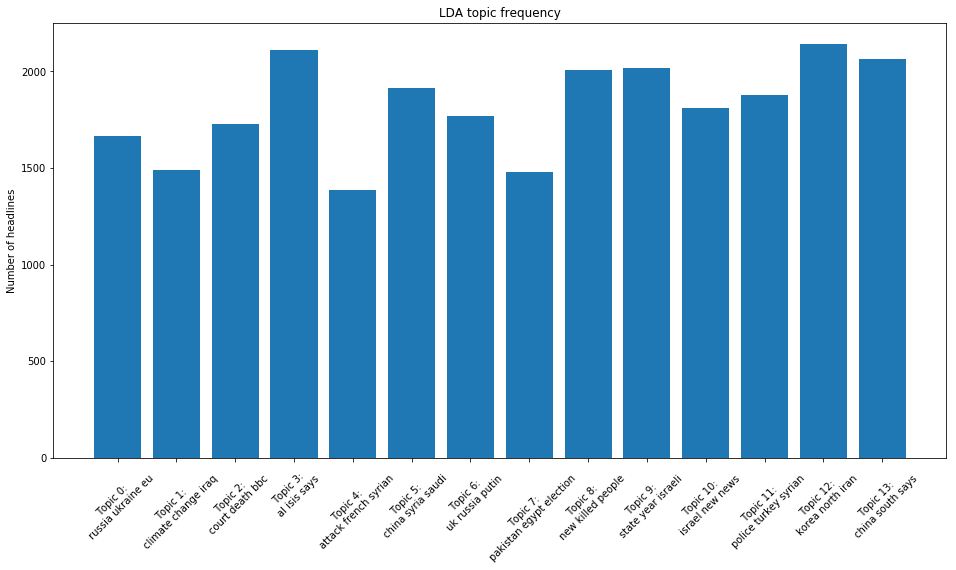

In [12]:
top_3_words = get_top_n_words(3, lda_keys, sampled_document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
plt.xticks(rotation=45)
ax.set_title('LDA topic frequency');
ax.set_ylabel('Number of headlines');

In [13]:
print "use t-SNE to visualize LDA high dimensional dataset"
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)


use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.023s...
[t-SNE] Computed neighbors for 25462 samples in 17.533s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabilities for sample 6000 / 25462
[t-SNE] Computed conditional probabilities for sample 7000 / 25462
[t-SNE] Computed conditional probabilities for sample 8000 / 25462
[t-SNE] Computed conditional probabilities for sample 9000 / 25462
[t-SNE] Computed conditional probabilities for sample 10000 / 25462
[t-SNE] Computed conditional probabilities for sample 11000 / 25462
[t-SNE] Computed conditional probabilities for sample 12000 / 25

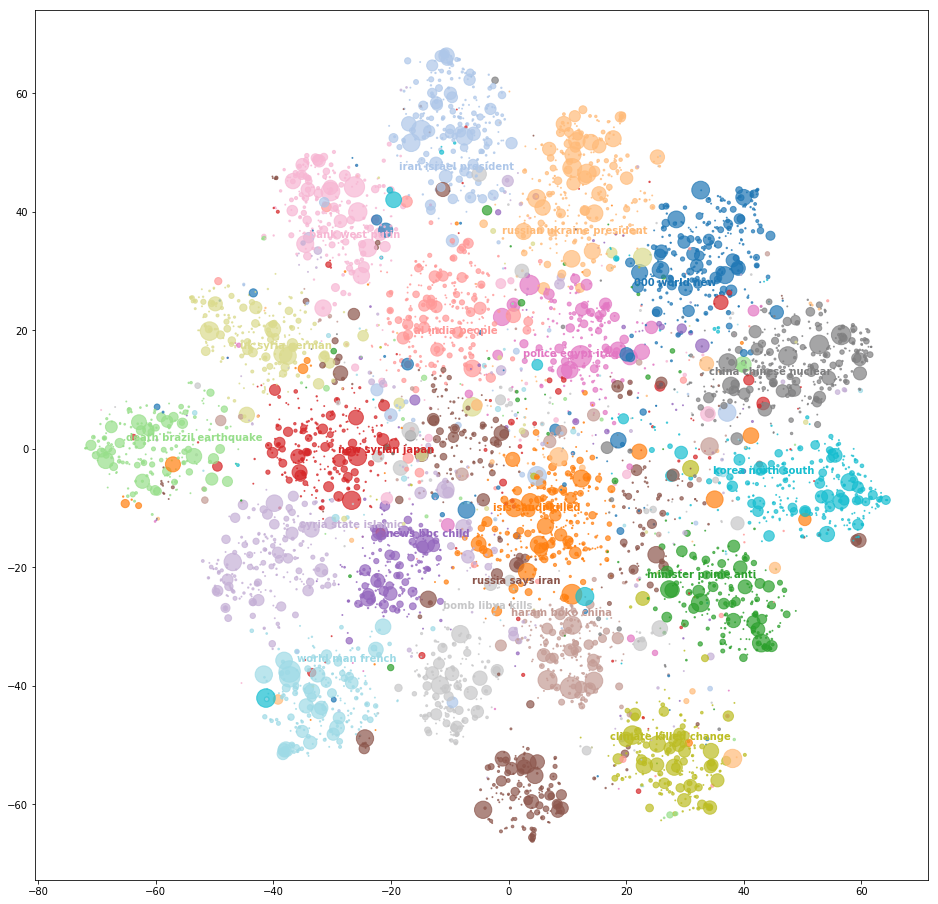

In [55]:
top_3_words_lda = get_top_n_words(3, lda_keys, sampled_document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)
fig, ax = plt.subplots(figsize=(16,16))
plt.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1],
            color=colormap[lda_keys],
            marker='o', s=sampled_up_votes_sizes, alpha=0.7)
for t in range(n_topics):
    plt.text(lda_mean_topic_vectors[t][0],
             lda_mean_topic_vectors[t][1],
             top_3_words[t], color=colormap[t],
             horizontalalignment='center', weight='bold')
plt.show()